In [4]:
import sys
sys.path.append('/work/mh0731/m300876/package/')
import icons
import intake
import matplotlib.pyplot as plt
import healpy as hp
import xarray as xr
import numpy as np
import easygems.healpix as egh
import seaborn as sns

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
icons.prepare_cpu(memory='100GB')

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-preset//proxy/36763/status,
Dashboard: /user/m300876/levante-spawner-preset//proxy/36763/status,Workers: 1
Total threads: 256,Total memory: 93.13 GiB
Status: running,Using processes: False
Comm: inproc://136.172.120.85/2046912/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-preset//proxy/36763/status,Total threads: 256
Started: Just now,Total memory: 93.13 GiB
Comm: inproc://136.172.120.85/2046912/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-preset//proxy/44503/status,Memory: 93.13 GiB
Nanny: None,


### Predefined functions

In [38]:
def preprocess(ds):
    """
    Adapts precipitation to the needs of this notebook.
    """
    ds = ds.assign(pr=(ds.pr * 86400).assign_attrs(units="mm d-1"))
    return ds

### Location mask
def tropics(ds):
    return np.abs(ds.lat) <= 30.1

def equator(ds):
    return np.abs(ds.lat) <= 5.1

def ocean(ds):
    return ds.ocean_fraction_surface == 1

def trop_wpacific(ds):
    return tropics(ds) & (ds.lon > 150) & (ds.lon < 170) 

def eq_wpacific(ds):
    return equator(ds) & (ds.lon > 150) & (ds.lon < 170) 

#### calculate mean
def net_toa(ds):
    return (ds.rsdt - ds.rsut - ds.rlut)

def net_surface(ds):
    return (ds.rsus - ds.rsds + ds.rlus - ds.rlds)

def net_cooling(ds):
    return net_toa(ds) + net_surface(ds)

def get_pe(ds):
    lv=22.6e5
    return (ds.pr*lv/ 86400 + ds.hflsd)

def net_fluxes(ds):
    return (-ds.hflsd - ds.hfssd)


## Calling data

In [7]:
%%time
### ICON
current_location = "online"
cat = cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
exp_name = "icon_d3hp003"
experiment = cat[exp_name]
time_slice = slice("2020-02-01", "2021-01-31")
ds_icon = (
    experiment(zoom=8, time="P1D", chunks="auto")
    .to_dask()
    .pipe(egh.attach_coords)
    .pipe(preprocess)
    .sel(time=time_slice)
).mean('time')


CPU times: user 1.32 s, sys: 539 ms, total: 1.86 s
Wall time: 7.79 s


In [18]:
%%time
### NICAM
exp_name = "nicam"
experiment = cat[exp_name]
time_slice = slice("2020-04-01", "2021-03-31")
ds_nicam = (
    experiment(zoom=8, time="PT3H", chunks="auto")
    .to_dask()
    .pipe(preprocess)
    .sel(time=time_slice)
)

ds_nicam = ds_nicam.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
).mean('time')

CPU times: user 268 ms, sys: 12.4 ms, total: 280 ms
Wall time: 2.99 s


In [76]:
%%time
### UM
exp_name = "um_glm_n2560_RAL3p3"
experiment = cat[exp_name]
time_slice = slice("2020-03-01", "2021-03-01")
ds_um = (
    experiment(zoom=8, time="PT1H", chunks="auto")
    .to_dask()
    .pipe(preprocess)
    .sel(time=time_slice)
)

ds_um = ds_um.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
).mean('time')

CPU times: user 337 ms, sys: 25.4 ms, total: 363 ms
Wall time: 3.49 s


In [34]:
%%time
qrad_icon = net_cooling(ds_icon.where(trop_wpacific(ds_icon))).compute()
qsurf_icon = net_fluxes(ds_icon.where(trop_wpacific(ds_icon))).compute()
pe_icon = get_pe(ds_icon.where(trop_wpacific(ds_icon))).compute()

CPU times: user 26.8 s, sys: 14.2 s, total: 41 s
Wall time: 23.6 s


In [19]:
%%time
qrad_nicam = net_cooling(ds_nicam.where(trop_wpacific(ds_nicam))).compute()
qsurf_nicam = net_fluxes(ds_nicam.where(trop_wpacific(ds_nicam))).compute()
pe_nicam = get_pe(ds_nicam.where(trop_wpacific(ds_nicam))).compute()

CPU times: user 7min 46s, sys: 1min 39s, total: 9min 25s
Wall time: 7min 15s


In [77]:
%%time
qrad_um = net_cooling(ds_um.where(trop_wpacific(ds_um))).compute()
qsurf_um = net_fluxes(ds_um.where(trop_wpacific(ds_um))).compute()
pe_um = get_pe(ds_um.where(trop_wpacific(ds_um))).compute()

AttributeError: 'Dataset' object has no attribute 'rsus'

In [40]:
gamma_icon_calc = (qsurf_icon + qrad_icon)/ (pe_icon)
gamma_nicam_calc = (qsurf_nicam + qrad_nicam)/ (pe_nicam)

In [49]:
hist_gammac_icon_wpacific= np.histogram((gamma_icon_calc).where( 
    eq_wpacific(gamma_icon_calc) & (pe_icon>0)),bins=np.arange(-2,2,0.1),
                                  density=True)

hist_gammac_nicam_wpacific = np.histogram((gamma_nicam_calc).where(
    eq_wpacific(gamma_nicam_calc) & (pe_nicam>0) ),bins=np.arange(-2,2,0.1),
                                  density=True)
                                                

In [60]:
def custom_plot(ax,ylabel=None,xlabel=None,title=None,xticklabels=False):
    sns.despine(offset=10, ax=ax)
    ax.set_xticks([-20,-5,0,5,20])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if xticklabels == False:
        ax.set_xticklabels({})    

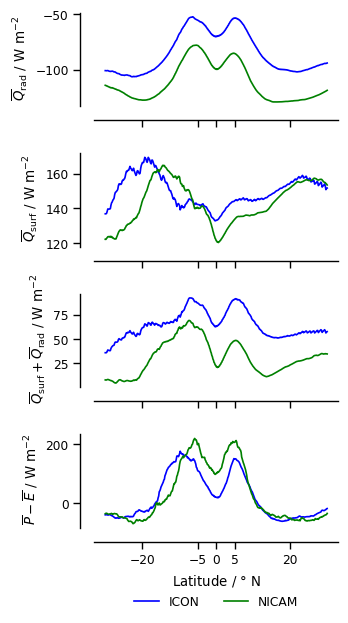

In [69]:
sns.set_context("paper")
fig = plt.figure(figsize=(8/2.54, 17/2.54), facecolor="white")

ax = fig.add_subplot(411)
qrad_icon.groupby("lat").mean().plot(color="b")
qrad_nicam.groupby("lat").mean().plot(color="green")
custom_plot(ax,ylabel=r" $\overline{Q}_\mathrm{rad}$ / W m$^{-2}$"
)

ax = fig.add_subplot(412)
qsurf_icon.groupby("lat").mean().plot(color="b")
qsurf_nicam.groupby("lat").mean().plot(color="green")
custom_plot(ax,ylabel=r" $\overline{Q}_\mathrm{surf}$ / W m$^{-2}$"
)

ax = fig.add_subplot(413)
(qsurf_icon+qrad_icon).groupby("lat").mean().plot(color="b")
(qsurf_nicam+qrad_nicam).groupby("lat").mean().plot(color="green")
custom_plot(ax,ylabel=r" $\overline{Q}_\mathrm{surf} + \overline{Q}_\mathrm{rad}$ / W m$^{-2}$"
)

ax = fig.add_subplot(414)
(pe_icon).groupby("lat").mean().plot(color="b",label='ICON')
(pe_nicam).groupby("lat").mean().plot(color="green",label='NICAM')
custom_plot(ax,ylabel=r" $\overline{P} - \overline{E}$ / W m$^{-2}$",
            xlabel=r"Latitude / $\degree$ N",xticklabels=True)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.6),
    ncol=3,
    fancybox=False,
    shadow=False,
    frameon=False
)
plt.subplots_adjust(hspace=0.5)

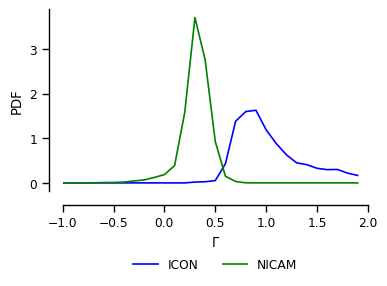

In [73]:
sns.set_context("paper")
fig = plt.figure(figsize=(10/2.54,6/2.54), facecolor="white")
ax = fig.add_subplot(1,1,1)
ax.plot(hist_gammac_icon_wpacific[1][1:],hist_gammac_icon_wpacific[0],'-b',label='ICON')
ax.plot(hist_gammac_nicam_wpacific[1][1:],hist_gammac_nicam_wpacific[0],'-g',label='NICAM')

plt.legend()
ax.set_xlim([-1,2])
sns.despine(offset=10)
ax.set_ylabel('PDF')
ax.set_xlabel(r'$\Gamma$')
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.5),
    ncol=2,
    fancybox=False,
    shadow=False,
    frameon=False
)

In [78]:
ds_um

<xarray.Dataset>
Dimensions:  (cell: 786432)
Coordinates:
  * cell     (cell) int64 0 1 2 3 4 5 ... 786427 786428 786429 786430 786431
    crs      float64 ...
    lat      (cell) float64 0.1492 0.2984 0.2984 ... -0.2984 -0.2984 -0.1492
    lon      (cell) float64 45.0 45.18 44.82 45.0 ... 315.0 315.2 314.8 315.0
Data variables: (12/24)
    clivi    (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    clt      (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    clwvi    (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    hflsd    (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    hfssd    (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    huss     (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    ...       ...
    rsut     (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    rsutcs   (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    tas      (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    ts       (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    uas      (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>
    vas      (cell) float32 dask.array<chunksize=(327680,), meta=np.ndarray>

In [86]:
exp_name = "um_glm_n1280_CoMA9_TBv1p2"
experiment = cat[exp_name]
time_slice = slice("2020-03-01", "2021-03-01")
ds_um2 = (
    experiment(zoom=6, time="PT1H", chunks="auto")
    .to_dask()
    .sel(time=time_slice)
)
ds_um2

<xarray.Dataset>
Dimensions:  (cell: 49152, time: 8784)
Coordinates:
  * cell     (cell) int64 0 1 2 3 4 5 6 ... 49146 49147 49148 49149 49150 49151
    crs      float64 ...
  * time     (time) datetime64[ns] 2020-03-01 ... 2021-03-01T23:00:00
Data variables: (12/26)
    clivi    (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    clt      (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    clwvi    (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    hflsd    (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    hfssd    (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    huss     (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    ...       ...
    rsutcs   (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    sftlf    (cell) float64 dask.array<chunksize=(49152,), meta=np.ndarray>
    tas      (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    ts       (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    uas      (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
    vas      (time, cell) float32 dask.array<chunksize=(296, 49152), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n1280_CoMA9